In [5]:
%pip install ipywidgets --upgrade

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import numpy as np
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [7]:
pretrained_model = "./bert/without_icl/roberta"
# pretrained_model = "jy46604790/Fake-News-Bert-Detect"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)
model.eval() # Set model to evaluation mode

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [8]:
# Check the class names (id2label mapping) from the model's configuration
class_names = model.config.id2label
print("Class names:", class_names)

Class names: {0: 'REAL', 1: 'FAKE'}


In [ ]:
def predict_proba(texts: list) -> np.ndarray:
    """Return an array of shape (len(texts), num_classes) with class probabilities for each input text."""
    # Tokenize the batch of texts
    encodings = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Move to GPU if available for speed (optional)
    # encodings = {k: v.to(device) for k,v in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits  # shape (batch_size, num_classes)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

In [ ]:
# Define class names for readability (optional, used by LIME for output)
class_names = ["false", "true"]

explainer = LimeTextExplainer(class_names=class_names)
text_instance = "Obama was born in Kenya and is a Muslim."  # a known false claim

# predicted_label = np.argmax(predict_proba([text_instance]), axis=1)[0]

exp = explainer.explain_instance(
    text_instance,                  # the text to explain
    model.predict,
    # predict_proba,                  # our prediction function
    num_features=10,                # number of words to show in explanation
    # labels=(predicted_label,)       # which class to explain; e.g., 0 corresponds to "pants-fire" if that's the predicted class
)

print("Predicted class:", class_names[np.argmax(predict_proba([text_instance]), axis=1)[0]])



In [ ]:
print(exp.as_list())


In [ ]:
print(exp.as_map())


In [ ]:
exp.save_to_file("lime_explanation.html")

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from lime.lime_text import LimeTextExplainer

# Load the pretrained RoBERTa model
model_path = "./bert/without_icl/roberta"  # Update this path if necessary
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# # Define the prediction function
# def predict_proba(texts):
#     inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
#     with torch.no_grad():
#         outputs = model(**inputs)
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
#     return probs.numpy()

def predict_proba(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    # Move inputs to the same device as the model
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # Move the output back to CPU and convert to numpy array if needed
    return probs.cpu().numpy()

# Define class names for readability (optional, used by LIME for output)
class_names = model.config.id2label
print("Class names:", class_names)

# Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Example text instance
# text_instance = "Obama was born in Kenya and is a Muslim."  # a known false claim
# text_instance = 'Video says COVID-19 vaccines are "weapons of mass destruction" that "could wipe out the human race.'  # pants-on-fire
# text_instance = "According to Michele Bachmann, the Chinese built a Great Wall 5,000 years ago. You don't see any illegal Mexicans in China."
# text_instance = "5G cellular networks cause COVID-19."
# text_instance = "Global warming stopped in 1998."
# text_instance = "Apple Inc. was founded by Steve Jobs, Steve Wozniak, and Ronald Wayne in 1976."
# text_instance = "BREAKING: Elon Musk will hold a Town Hall in Green Bay, Wisconsin on Sunday at 6:30pm CT. Entrance is limited to those who have signed the petition in opposition to activist judges. It will be livestreamed on X."
text_instance = (
    "Subject: political; " +
    "Speaker: yixiang; " + 
    "Speaker description: yixiang is a student studying in national university of singapore; " + 
    "State info: singapore; " + 
    "Context: a tweet; " +
    "Statement: " +   
    "Joe Biden was inaugurated as the 46th President of the United States on January 20, 2021."
)

# Explain the instance
exp = explainer.explain_instance(
    text_instance,                  # the text to explain
    predict_proba,                  # our prediction function
    num_features=10,                 # number of words to show in explanation
    # labels=(0,),
    # num_samples=5000
)

# Print the predicted class
predicted_class = np.argmax(predict_proba([text_instance]), axis=1)[0]
print("Predicted class:", class_names[predicted_class])

print(exp.as_list())

# Save the explanation to an HTML file (optional)
exp.save_to_file("lime_explanation.html")

cuda
Class names: {0: 'REAL', 1: 'FAKE'}
Predicted class: REAL
[(np.str_('tweet'), 0.16148420524219648), (np.str_('singapore'), -0.10505299772781576), (np.str_('university'), -0.06338124339856428), (np.str_('of'), -0.06155377243072873), (np.str_('46th'), -0.0510332698723077), (np.str_('national'), -0.04190997159994926), (np.str_('Context'), 0.0357966842041984), (np.str_('inaugurated'), -0.03577006630355189), (np.str_('info'), 0.020371039848372262), (np.str_('Statement'), 0.019292686606090993)]


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import re
from lime.lime_text import LimeTextExplainer

# Load the pretrained RoBERTa model
model_path = "./bert/without_icl/roberta"  # Update this path if necessary
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set the model to evaluation mode

# Define the prediction function
def predict_proba(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.numpy()

# Define class names for readability (optional, used by LIME for output)
class_names = ["REAL", "FAKE"]
print("Class names:", class_names)

def preprocess_for_lime(text_instance):
    statement = text_instance.split("Statement: ")[-1]
    return re.split(r'\W+', statement)

# Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=class_names, split_expression=preprocess_for_lime)

# Example text instance
text_instance = (
    "Subject: political; " +
    "Speaker: yixiang; " + 
    "Speaker description: yixiang is a student studying in national university of singapore; " + 
    "State info: singapore; " + 
    "Context: a tweet; " +
    "Statement: " +   
    "Joe Biden was inaugurated as the 46th President of the United States on January 20, 2021."
)

# Print the predicted class
predicted_class = np.argmax(predict_proba([text_instance]), axis=1)[0]
print("Predicted class:", class_names[predicted_class])

# Explain the instance
exp = explainer.explain_instance(
    text_instance,                  # the text to explain
    predict_proba,                  # our prediction function
    num_features=5,                 # number of words to show in explanation
    labels=[predicted_class],
    # num_samples=5000
)

# Save the explanation to an HTML file (optional)
exp.save_to_file("lime_explanation_2.html")

Class names: {0: 'REAL', 1: 'FAKE'}
Predicted class: REAL


In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Define a custom tokenizer that only focuses on the first sentence
def custom_tokenizer(text):
    # Split the full text into sentences (using '.' as a simple delimiter)
    sentences = text.split('.')
    # Use tokens only from the first sentence (if available)
    if sentences and sentences[0]:
        return sentences[0].split()
    else:
        return text.split()

# Create the LimeTextExplainer with the custom tokenizer
explainer = LimeTextExplainer(class_names=['negative', 'positive'],
                              split_expression=custom_tokenizer)

# Define a dummy prediction function that uses the full text for predictions.
# Replace this with your actual model prediction function.
def predict_proba(texts):
    # For demonstration, every input is assigned the same probabilities.
    return np.array([[0.3, 0.7] for _ in texts])

# Example input text; the full text is used by predict_proba, but the explanation
# will focus on the first sentence due to our custom tokenizer.
text_instance = ("This is the first sentence we want to explain. "
                 "This second sentence provides additional context but will be ignored in the explanation. "
                 "And here is yet another sentence.")

# Generate the explanation using LIME
explanation = explainer.explain_instance(text_instance, predict_proba, num_features=5)

# Display the explanation (works well in a Jupyter Notebook)
explanation.show_in_notebook(text=True)
explanation.save_to_file("lime_explanation.html")


In [5]:
import re

text = "Joe Biden was inaugurated as the 46th President of the United States on January 20, 2021."
tokens = re.split(r'\W+', text)
print(tokens)


['Joe', 'Biden', 'was', 'inaugurated', 'as', 'the', '46th', 'President', 'of', 'the', 'United', 'States', 'on', 'January', '20', '2021', '']


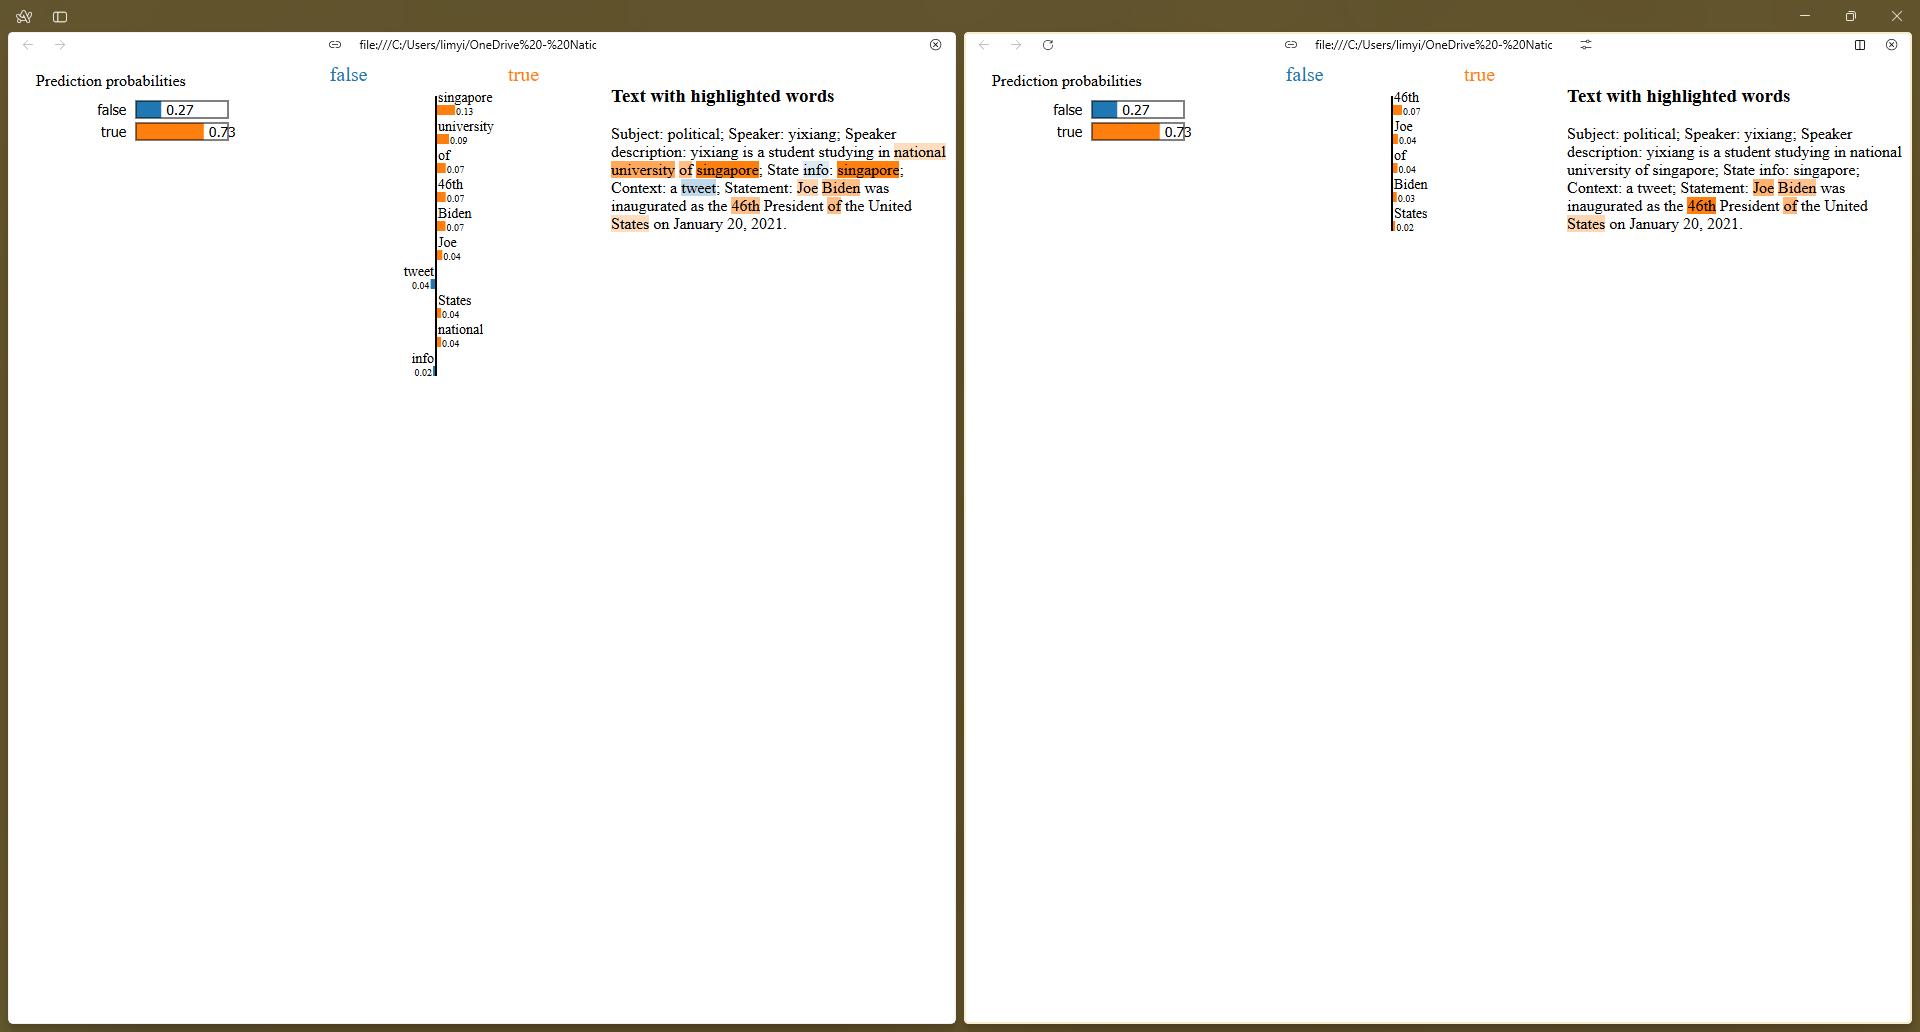

In [ ]:
# Using GPU

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import re
import multiprocessing
import pandas as pd
from lime.lime_text import LimeTextExplainer
from datasets import load_dataset

# Load the pretrained RoBERTa model
model_path = "/kaggle/input/roberta_without_icl/pytorch/default/1/roberta"  # Update this path if necessary
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# def predict_proba(texts):
#     inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
#     # Move inputs to the same device as the model
#     inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
#     with torch.no_grad():
#         outputs = model(**inputs)
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
#     # Move the output back to CPU and convert to numpy array if needed
#     return probs.cpu().numpy()

def predict_proba(texts, batch_size=32):
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i: i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        all_probs.append(probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)



# Define class names for readability (optional, used by LIME for output)
class_names = ["REAL", "FAKE"]
print("Class names:", class_names)

def preprocess_for_lime(text_instance):
    statement = text_instance.split("Statement: ")[-1]
    return re.split(r'\W+', statement)

# Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=class_names, split_expression=preprocess_for_lime)

# Load dataset
dataset = load_dataset("chengxuphd/liar2")

def preprocess_text(examples):
    combined_input = [
        "Subject: " + (subject if subject is not None else "") + 
        "; Speaker: " + (speaker if speaker is not None else "") + 
        "; Speaker Description: " + (speaker_description if speaker_description is not None else "") + 
        "; State: " + (state_info if state_info is not None else "") + 
        "; Context: " + (context if context is not None else "") + 
        "; Statement: " + (statement if statement is not None else "")
        for subject, speaker, speaker_description, state_info, context, statement in zip(
            examples["subject"],
            examples["speaker"],
            examples["speaker_description"],
            examples["state_info"],
            examples["context"],
            examples["statement"]
        )
    ]
    return combined_input

texts = preprocess_text(dataset["test"])

# Print the predicted class
# predicted_class = np.argmax(predict_proba([text_instance]), axis=1)[0]
# print("Predicted class:", class_names[predicted_class])

def get_top_keywords(explanation):
    # explanation.as_list() returns a list of (feature, weight) pairs.
    # Sort by the absolute value of the weight in descending order.
    sorted_features = sorted(explanation.as_list(), key=lambda x: abs(x[1]), reverse=True)
    # Return the top 'top' feature names.
    return [feature for feature, weight in sorted_features]


def explain_and_extract(row_text):
    # Generate explanation for the row.
    explanation = explainer.explain_instance(
        row_text, 
        predict_proba, 
        labels=[0, 1], 
        num_samples=2500, 
        num_features=5
    )
    # Extract the top 5 keywords.
    top_keywords = get_top_keywords(explanation)
    return top_keywords

def save_batch_csv(results, output_loc):
    # Convert each inner list into a single string (joined with a space)
    joined_results = [' '.join(inner_list) for inner_list in results]
    
    # Create a DataFrame with one column (e.g., "keywords")
    df = pd.DataFrame({'keywords': joined_results})
    
    # Save the DataFrame to a CSV file without adding the row index
    df.to_csv(output_loc, index=False)

num_texts = len(texts)
print("Number of texts to process:", num_texts)
first_batch_500 = texts[:500]
first_results = []
second_batch_1000 = texts[500:1000]
second_results = []
third_batch_1500 = texts[1000:1500]
third_results = []
fourth_batch_2000 = texts[1500:2000]
fourth_results = []
last_batch_2296 = texts[2000:]
last_results = []
counter = 0

for text in first_batch_500:
    if counter % 10 == 0:
        print("Number of texts processed:", counter)
    top_keywords = explain_and_extract(text)
    first_results.append(top_keywords)
    counter += 1
save_batch_csv(first_results, "/kaggle/working/first_batch.csv")
print("First batch of 500 finished and saved.")

for text in second_batch_1000:
    if counter % 10 == 0:
        print("Number of texts processed:", counter)
    top_keywords = explain_and_extract(text)
    second_results.append(top_keywords)
    counter += 1
save_batch_csv(second_results, "/kaggle/working/second_batch.csv")
print("Second batch of 500 finished and saved.")

for text in third_batch_1500:
    if counter % 10 == 0:
        print("Number of texts processed:", counter)
    top_keywords = explain_and_extract(text)
    third_results.append(top_keywords)
    counter += 1
save_batch_csv(third_results, "/kaggle/working/third_batch.csv")
print("Third batch of 500 finished and saved.")

for text in fourth_batch_2000:
    if counter % 10 == 0:
        print("Number of texts processed:", counter)
    top_keywords = explain_and_extract(text)
    fourth_results.append(top_keywords)
    counter += 1
save_batch_csv(fourth_results, "/kaggle/working/fourth_batch.csv")
print("Fourth batch of 500 finished and saved.")

for text in last_batch_2296:
    if counter % 10 == 0:
        print("Number of texts processed:", counter)
    top_keywords = explain_and_extract(text)
    last_results.append(top_keywords)
    counter += 1
save_batch_csv(last_results, "/kaggle/working/last_batch.csv")
print("Last batch finished and saved.")

results = first_results + second_results + third_results + fourth_results + last_results
print("Total keywords extracted:", len(results))
dataset = dataset["test"]
dataset.add_column("keywords", results)
dataset.to_csv("/kaggle/working/test_dataset_with_keywords_without_icl.csv")
print("Saved final dataset.")